In [1]:
import os
import sys
import math
import argparse
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from typing import Dict, List, Tuple, Iterable, Union, Optional, Set, Sequence, Callable, DefaultDict, Any

# Keras imports
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, PReLU, ELU, ThresholdedReLU, Lambda, Reshape, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, add, concatenate
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Flatten, LSTM, RepeatVector
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D, UpSampling1D, UpSampling2D, UpSampling3D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling1D, AveragePooling2D, AveragePooling3D, Layer
from tensorflow.keras.layers import SeparableConv1D, SeparableConv2D, DepthwiseConv2D, Concatenate, Add
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, GlobalAveragePooling3D

# ML4CVD Imports
from ml4cvd.TensorMap import TensorMap
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_multitask_model, train_model_from_generators, make_hidden_layer_model, _conv_layer_from_kind_and_dimension
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [2]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/segmented-sax-lax/2020-07-07/', 
            '--input_tensors', 'lax_4ch_diastole_slice0_224_3d', 
            '--output_tensors', 'lax_4ch_diastole_slice0_224_3d',
            '--u_connect', 'lax_4ch_diastole_slice0_128_3d', 'lax_4ch_diastole_slice0_128_3d',
            '--batch_size', '2',
            '--epochs', '2',
            '--conv_x', '71',
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--num_workers', '0',
            '--model_file', '/home/sam/ml/trained_models/lax_4ch_diastole_autoencode_unet/lax_4ch_diastole_autoencode_unet.h5',
            '--id', 'lax_4ch_diastole_autoencode_leaky']
args = parse_args()
model = make_multimodal_multitask_model(**args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(generate_test, args.test_steps)
latent_dimension = 8960

2020-07-27 15:50:51,121 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/lax_4ch_diastole_autoencode_leaky/log_2020-07-27_15-50_0.log.
2020-07-27 15:50:51,122 - arguments:423 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/segmented-sax-lax/2020-07-07/ --input_tensors lax_4ch_diastole_slice0_224_3d --output_tensors lax_4ch_diastole_slice0_224_3d --u_connect lax_4ch_diastole_slice0_128_3d lax_4ch_diastole_slice0_128_3d --batch_size 2 --epochs 2 --conv_x 71 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 1 --num_workers 0 --model_file /home/sam/ml/trained_models/lax_4ch_diastole_autoencode_unet/lax_4ch_diastole_autoencode_unet.h5 --id lax_4ch_diastole_autoencode_leaky

2020-07-27 15:50:51,123 - arguments:424 - INFO - Total TensorMaps: 599 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice

2020-07-27 15:50:53,630 - tensor_generators:659 - INFO - Found 31871 train, 9242 validation, and 4569 testing tensors at: /mnt/disks/segmented-sax-lax/2020-07-07/
2020-07-27 15:50:53,656 - tensor_generators:151 - INFO - Started 1 test workers with cache size 0.000 GB.
2020-07-27 15:50:53,712 - tensor_generators:504 - INFO - Made a big batch of tensors with key:input_lax_4ch_diastole_slice0_224_3d_continuous and shape:(2, 224, 160, 1).
2020-07-27 15:50:53,713 - tensor_generators:504 - INFO - Made a big batch of tensors with key:output_lax_4ch_diastole_slice0_224_3d_continuous and shape:(2, 224, 160, 1).


In [3]:
def plot_ae_towards_attractor(model, matrix, samples=6, steps = 30):
    sample_every = steps//samples
    fig, axes = plt.subplots(1, samples, figsize=(samples*16,16))
    col = 0
    for i in range(steps):
        if i % sample_every == 0 and col < samples:
            axes[col].imshow(matrix[0, :, :, 0], cmap = 'gray')
            axes[col].set_yticks(())
            col += 1
        matrix = model.predict(matrix)   
    return matrix

### Reconstructions from U-net ConvNet are smooth, capture main caridac chambers, but lose fine details

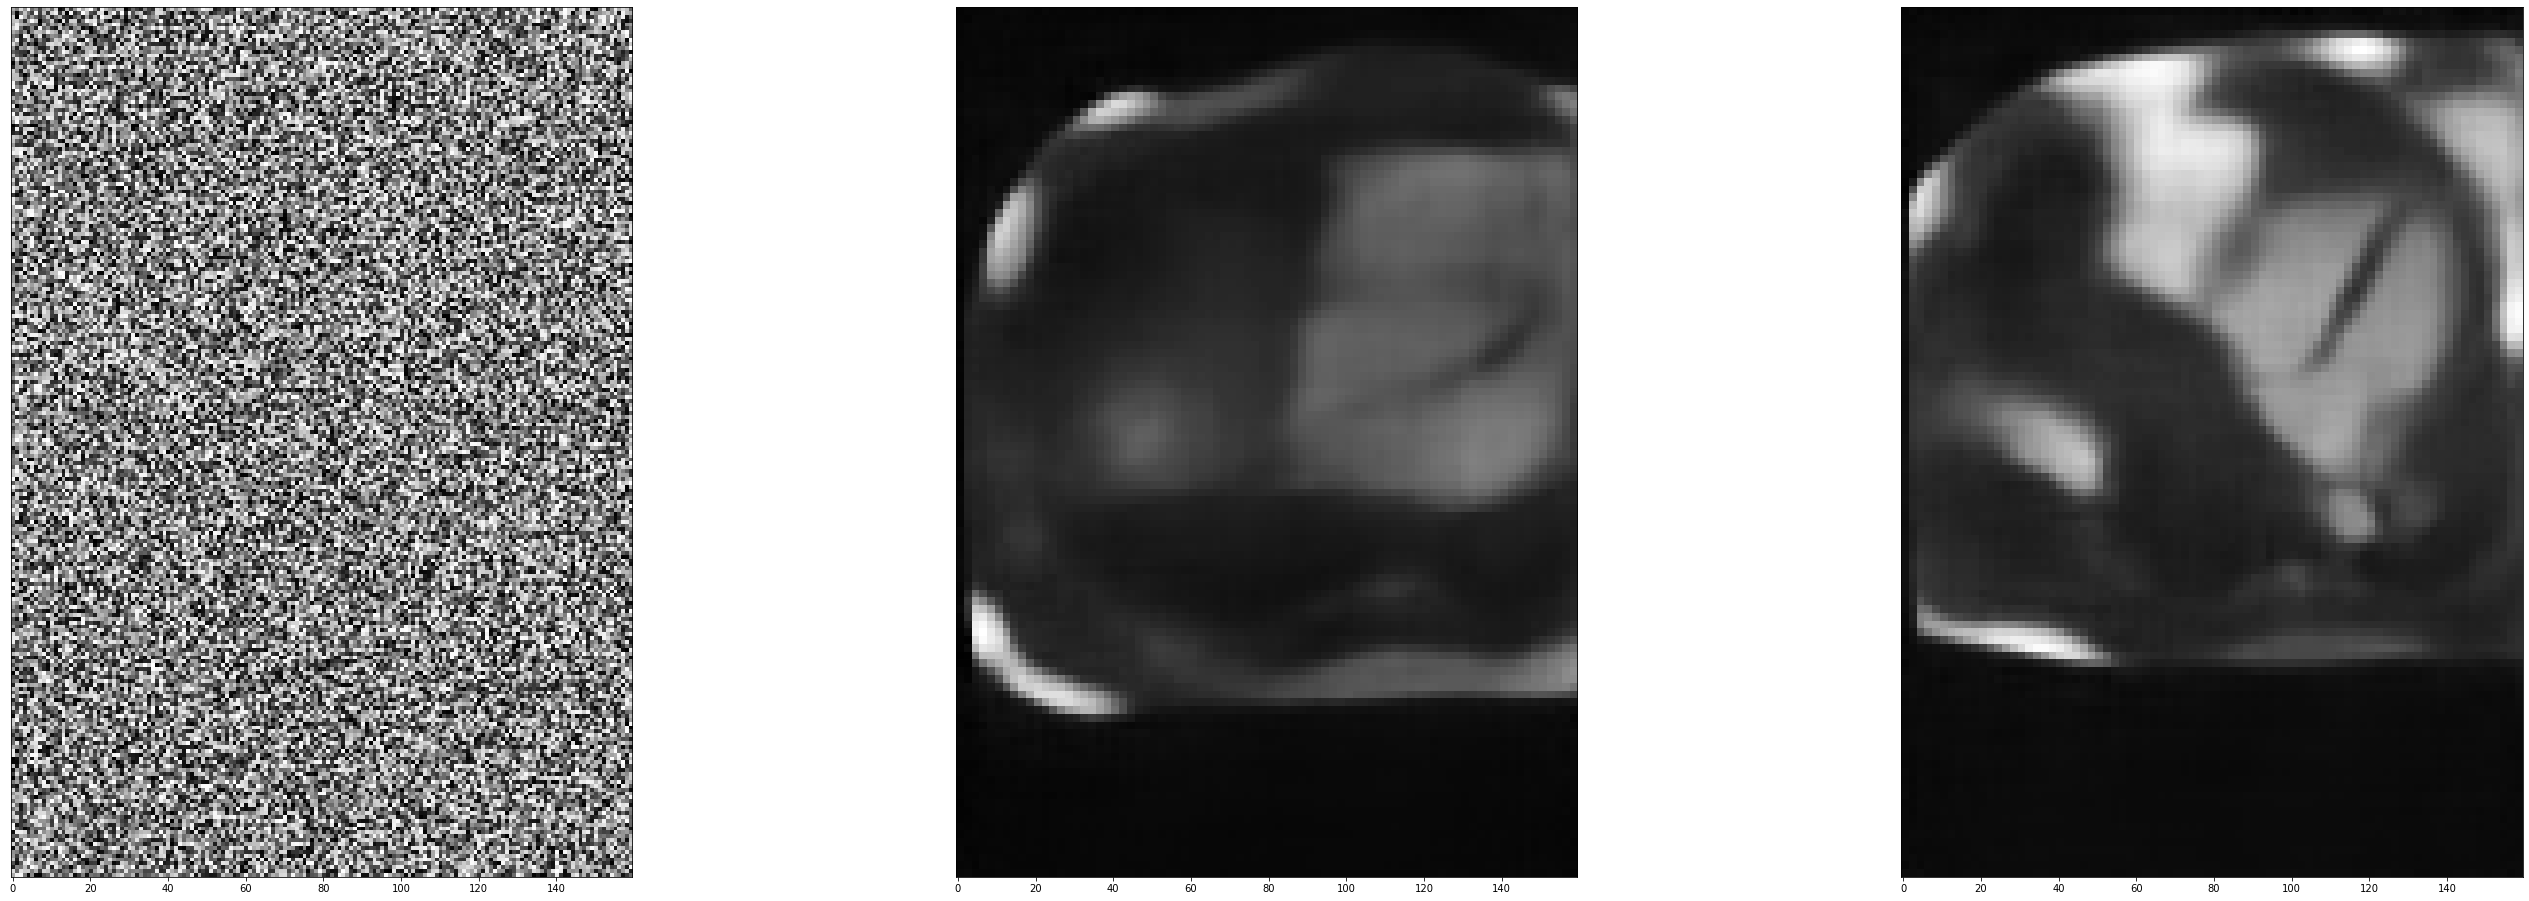

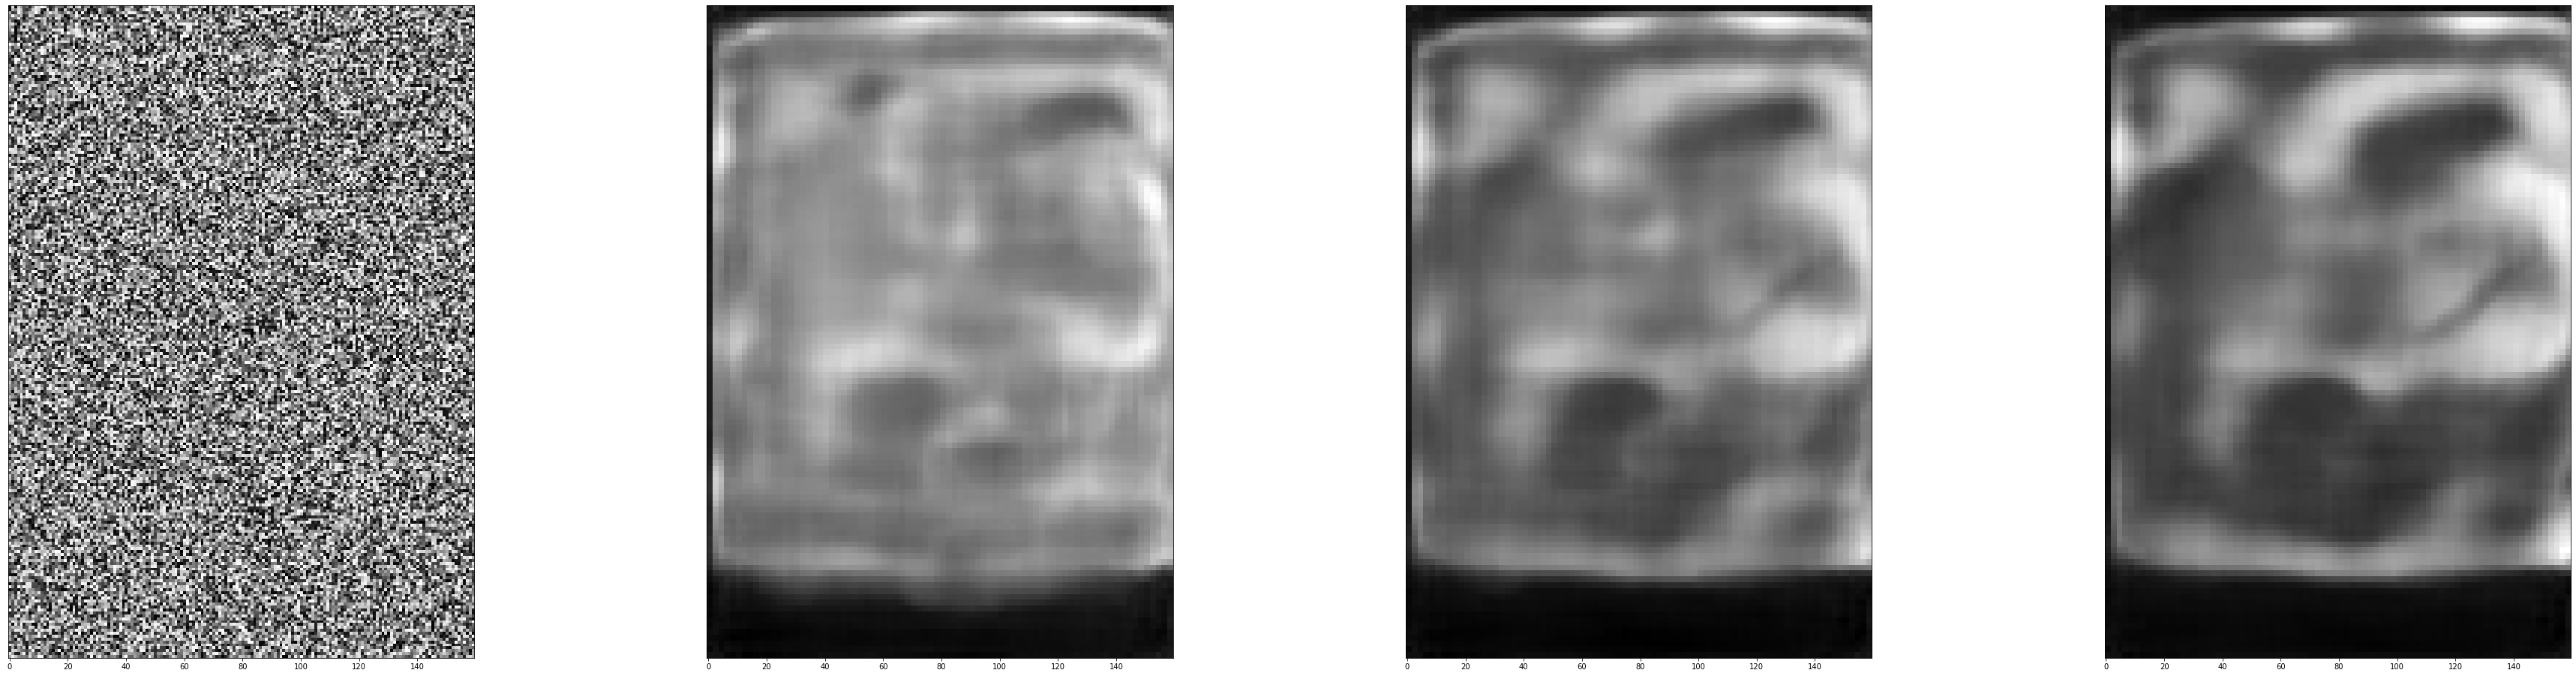

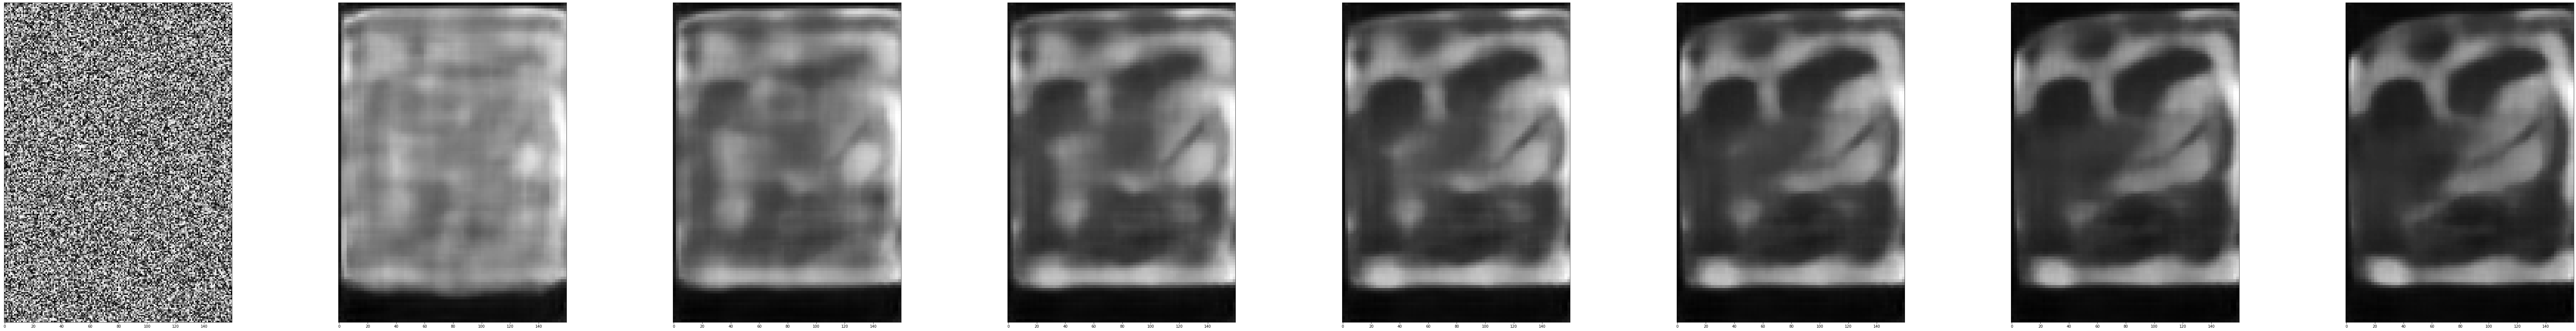

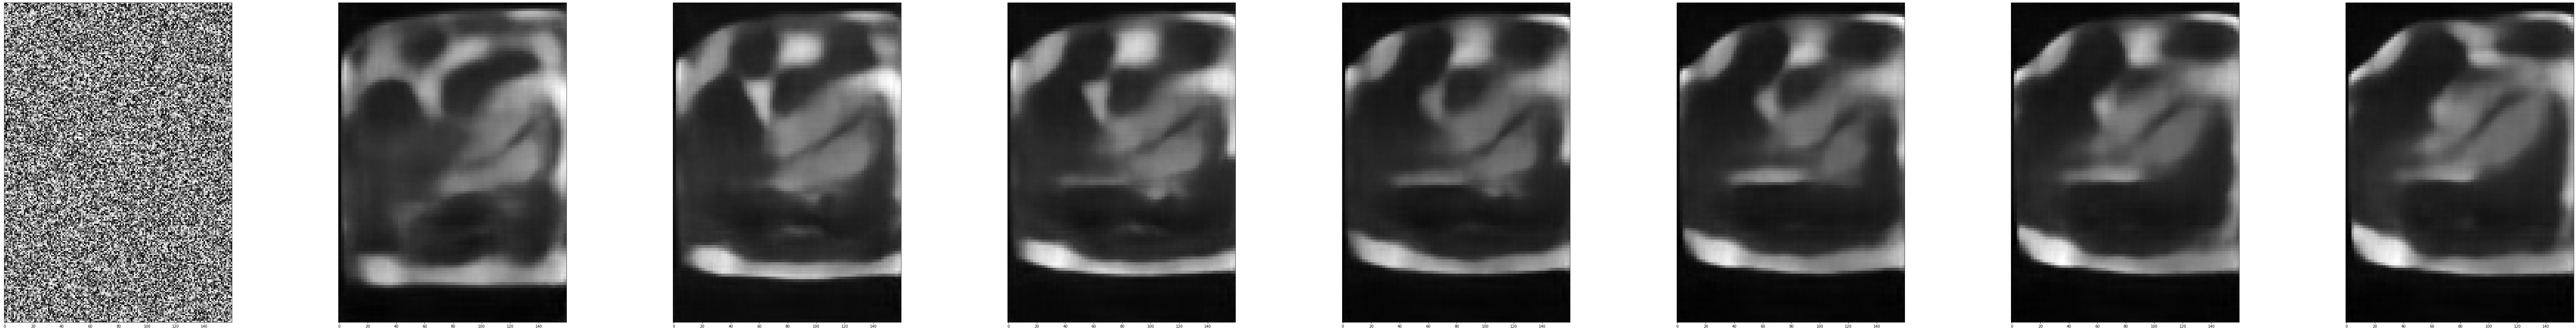

In [6]:
m = plot_ae_towards_attractor(model,  np.random.uniform(-1, 1, (1,224,160,1)), samples = 3, steps=150)
m = plot_ae_towards_attractor(model,  np.random.uniform(-1, 1, (1,224,160,1)), samples = 4, steps=4)
m = plot_ae_towards_attractor(model,  np.random.random((1,224,160,1)), samples=8, steps = 8)
m = plot_ae_towards_attractor(model,  np.random.random((1,224,160,1)), samples=8, steps = 48)

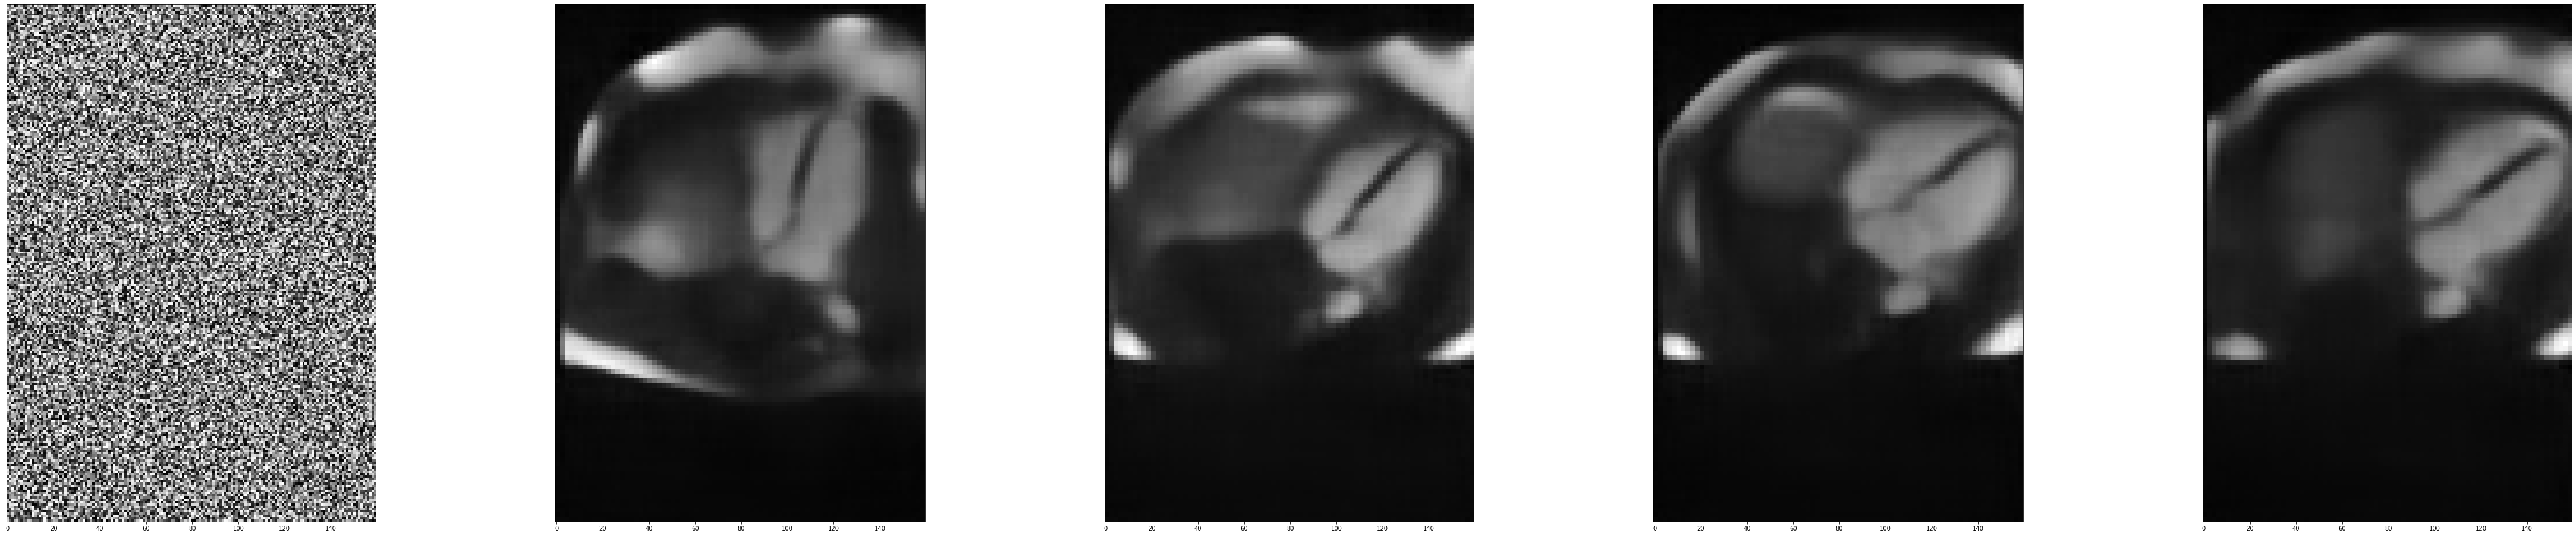

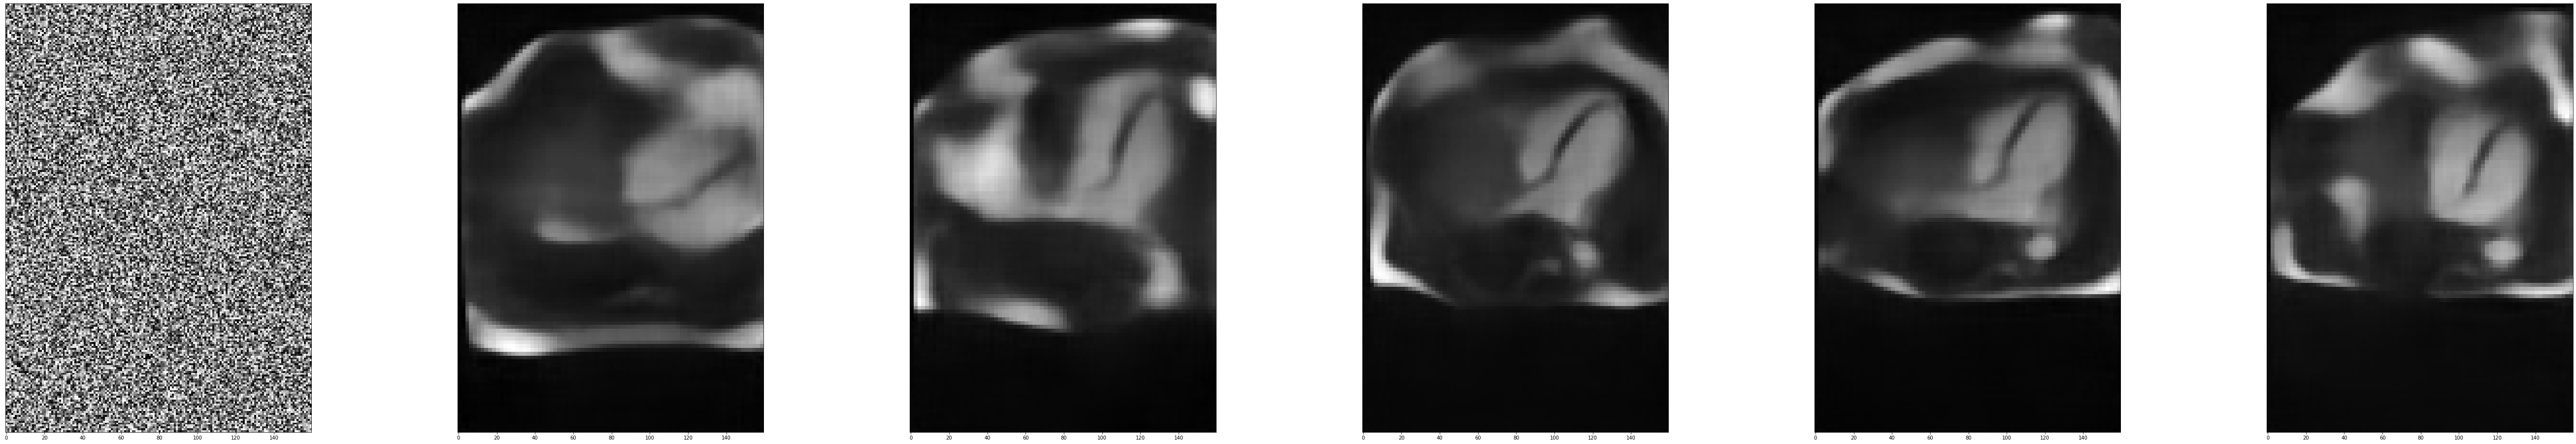

In [54]:
m = plot_ae_towards_attractor(model,  np.random.random((1,224,160,1)), samples=5, steps = 500)
m = plot_ae_towards_attractor(model,  np.random.uniform(-1, 1, (1,224,160,1)), steps=250)

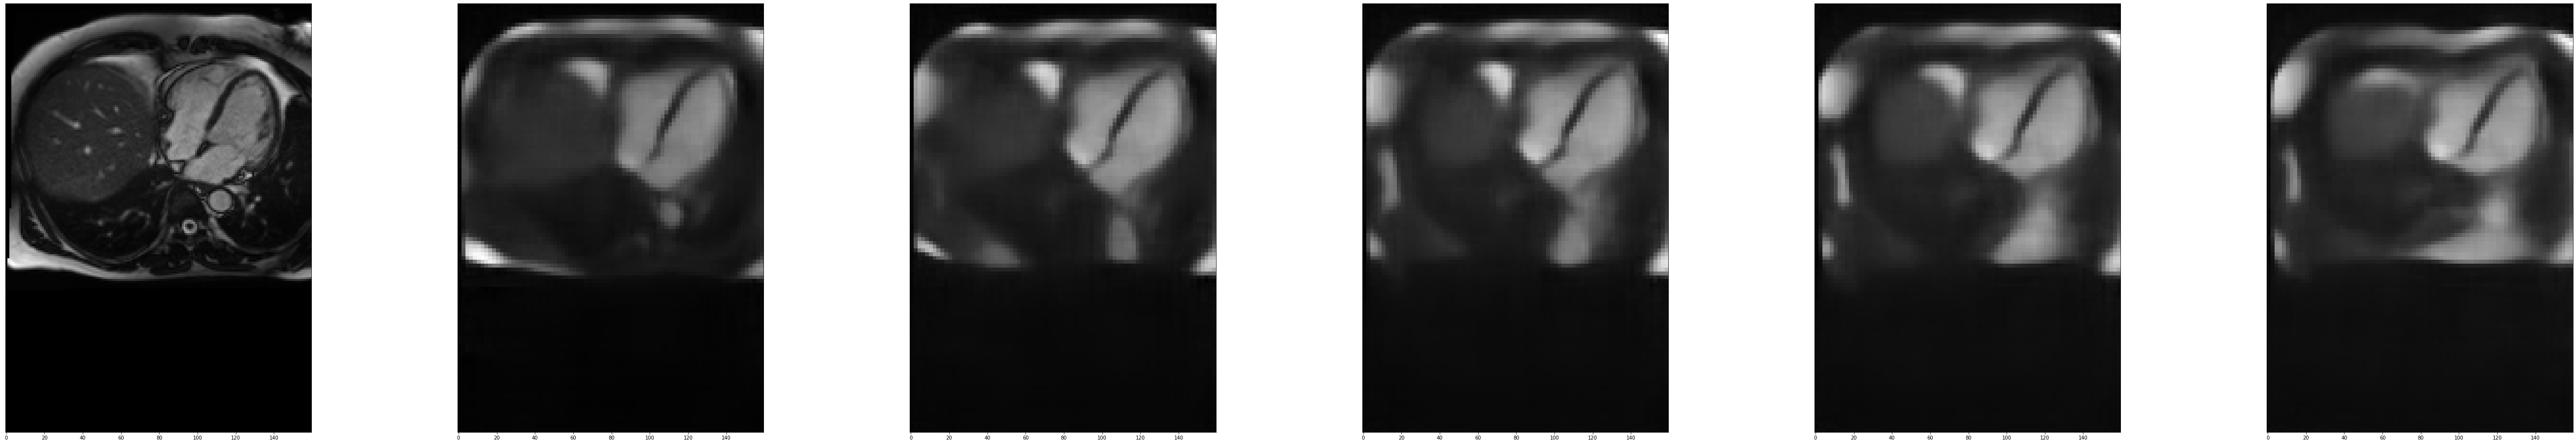

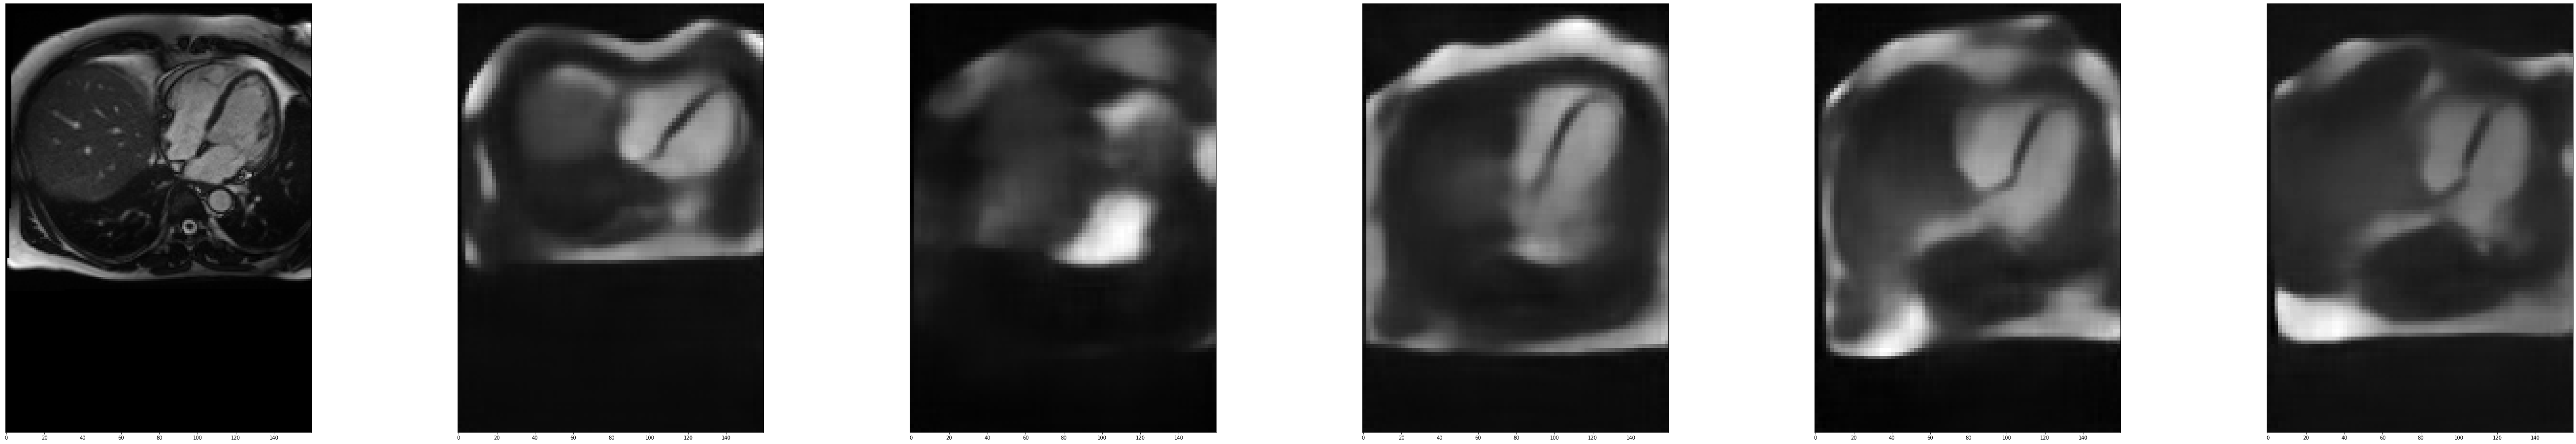

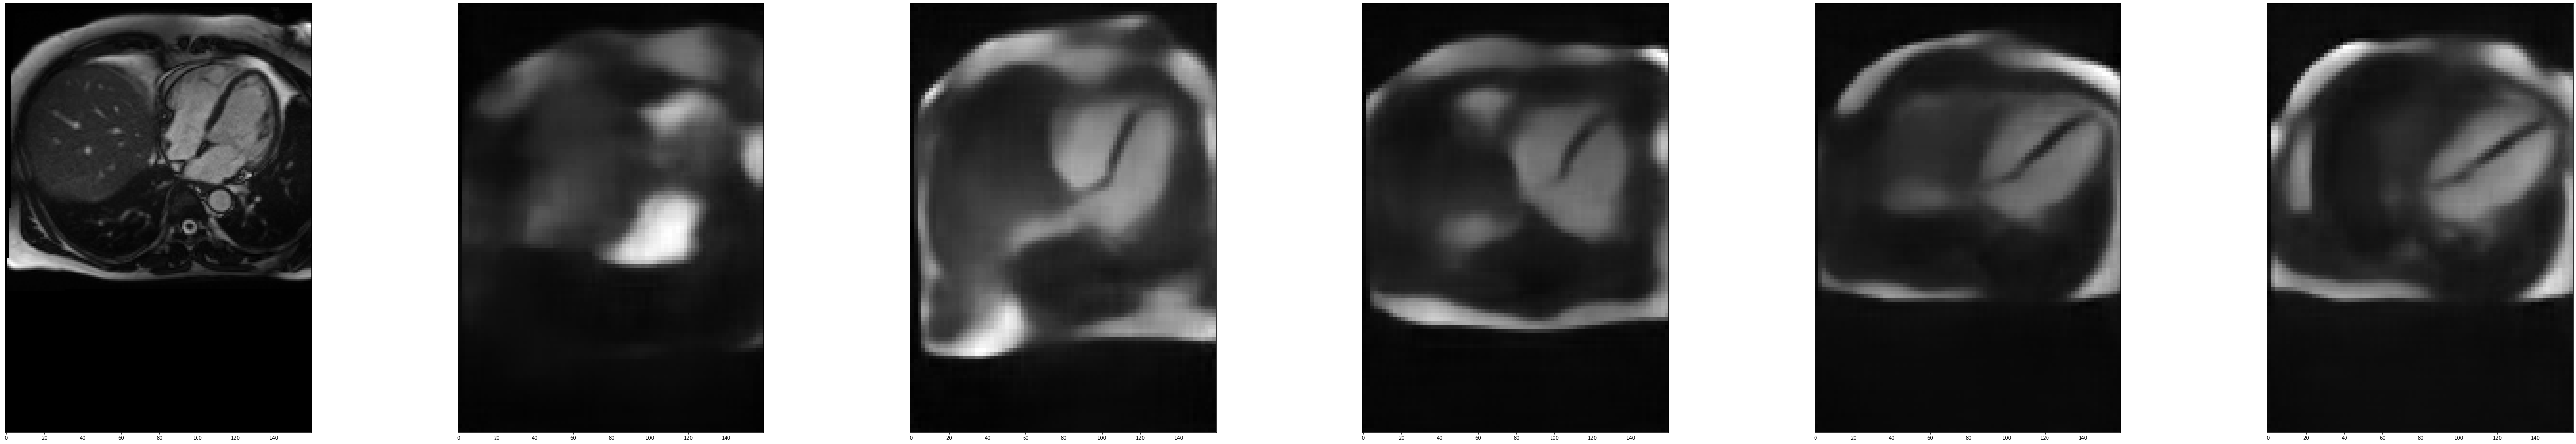

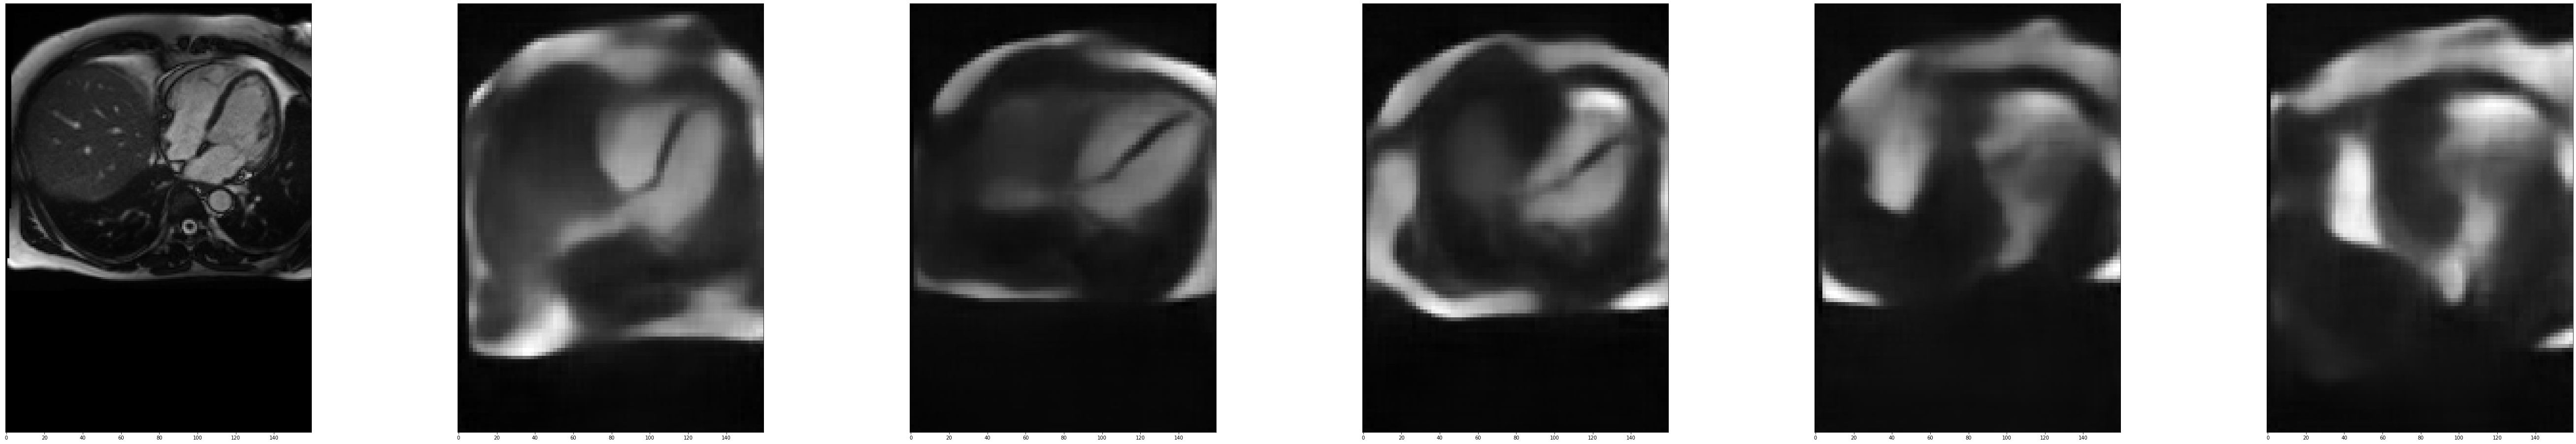

In [9]:
m = plot_ae_towards_attractor(model,  test_data['input_lax_4ch_diastole_slice0_224_3d_continuous'])
m = plot_ae_towards_attractor(model,  test_data['input_lax_4ch_diastole_slice0_224_3d_continuous'], steps=200)
m = plot_ae_towards_attractor(model,  test_data['input_lax_4ch_diastole_slice0_224_3d_continuous'], steps=400)
m = plot_ae_towards_attractor(model,  test_data['input_lax_4ch_diastole_slice0_224_3d_continuous'], steps=800)

In [12]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/segmented-sax-lax/2020-07-07/', 
            '--input_tensors', 'lax_4ch_diastole_slice0_224_3d', 
            '--output_tensors', 'lax_4ch_diastole_slice0_224_3d',
            '--batch_size', '2',
            '--epochs', '2',
            '--conv_x', '71',
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--num_workers', '0',
            '--model_file', '/home/sam/ml/trained_models/lax_4ch_diastole_autoencode_leaky2/lax_4ch_diastole_autoencode_leaky2.h5',
            '--id', 'lax_4ch_diastole_autoencode_leaky']
args = parse_args()
model = make_multimodal_multitask_model(**args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
latent_dimension = 128

2020-07-27 16:01:46,033 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/lax_4ch_diastole_autoencode_leaky/log_2020-07-27_16-01_0.log.
2020-07-27 16:01:46,034 - arguments:423 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/segmented-sax-lax/2020-07-07/ --input_tensors lax_4ch_diastole_slice0_224_3d --output_tensors lax_4ch_diastole_slice0_224_3d --batch_size 2 --epochs 2 --conv_x 71 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 1 --num_workers 0 --model_file /home/sam/ml/trained_models/lax_4ch_diastole_autoencode_leaky2/lax_4ch_diastole_autoencode_leaky2.h5 --id lax_4ch_diastole_autoencode_leaky

2020-07-27 16:01:46,035 - arguments:424 - INFO - Total TensorMaps: 599 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=2, bigquery_credentials_file=

2020-07-27 16:01:48,466 - tensor_generators:659 - INFO - Found 31871 train, 9242 validation, and 4569 testing tensors at: /mnt/disks/segmented-sax-lax/2020-07-07/


### Reconstructions from ConvNet without U-net Skip connections are not as good
- scaling artifacts
- cardiac chambers not really discernible

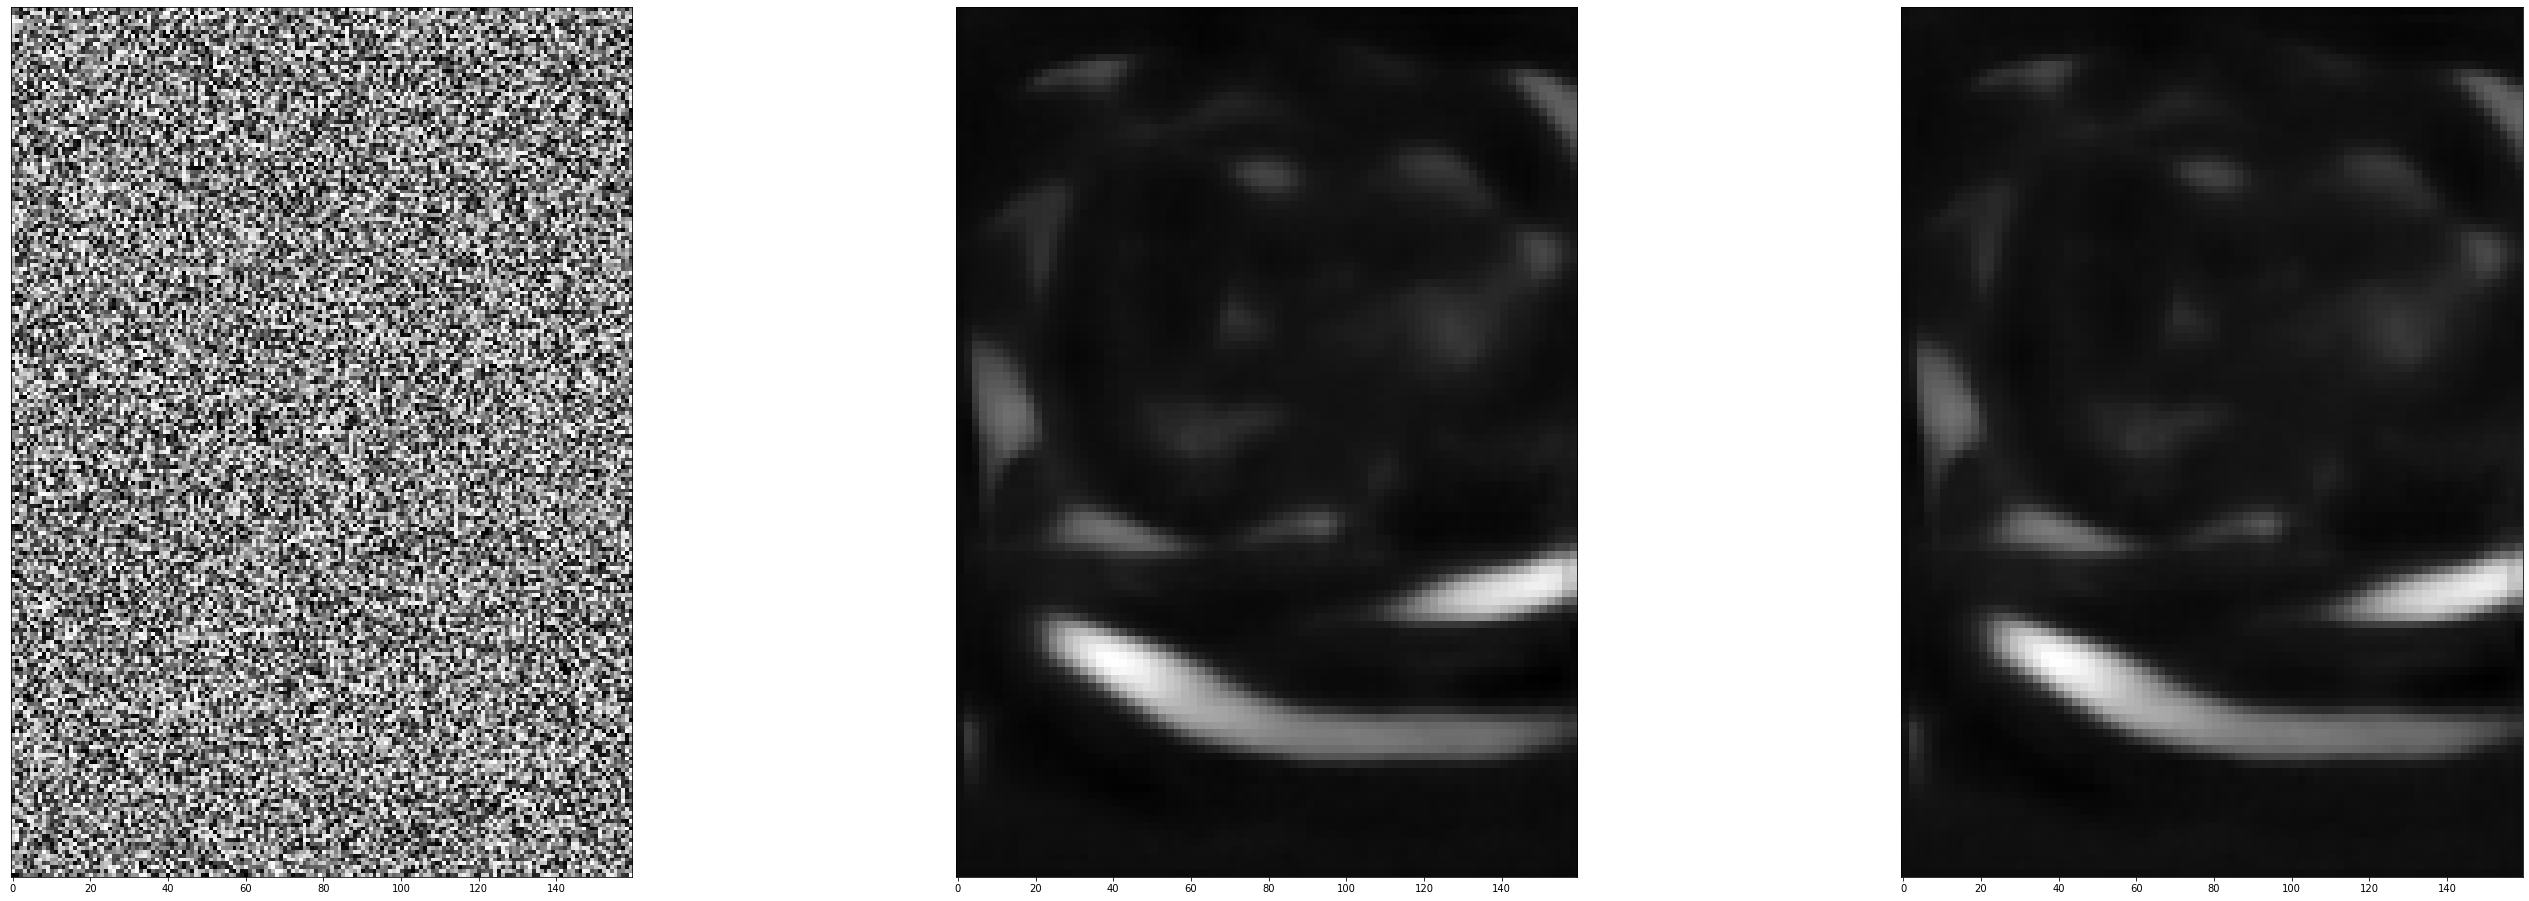

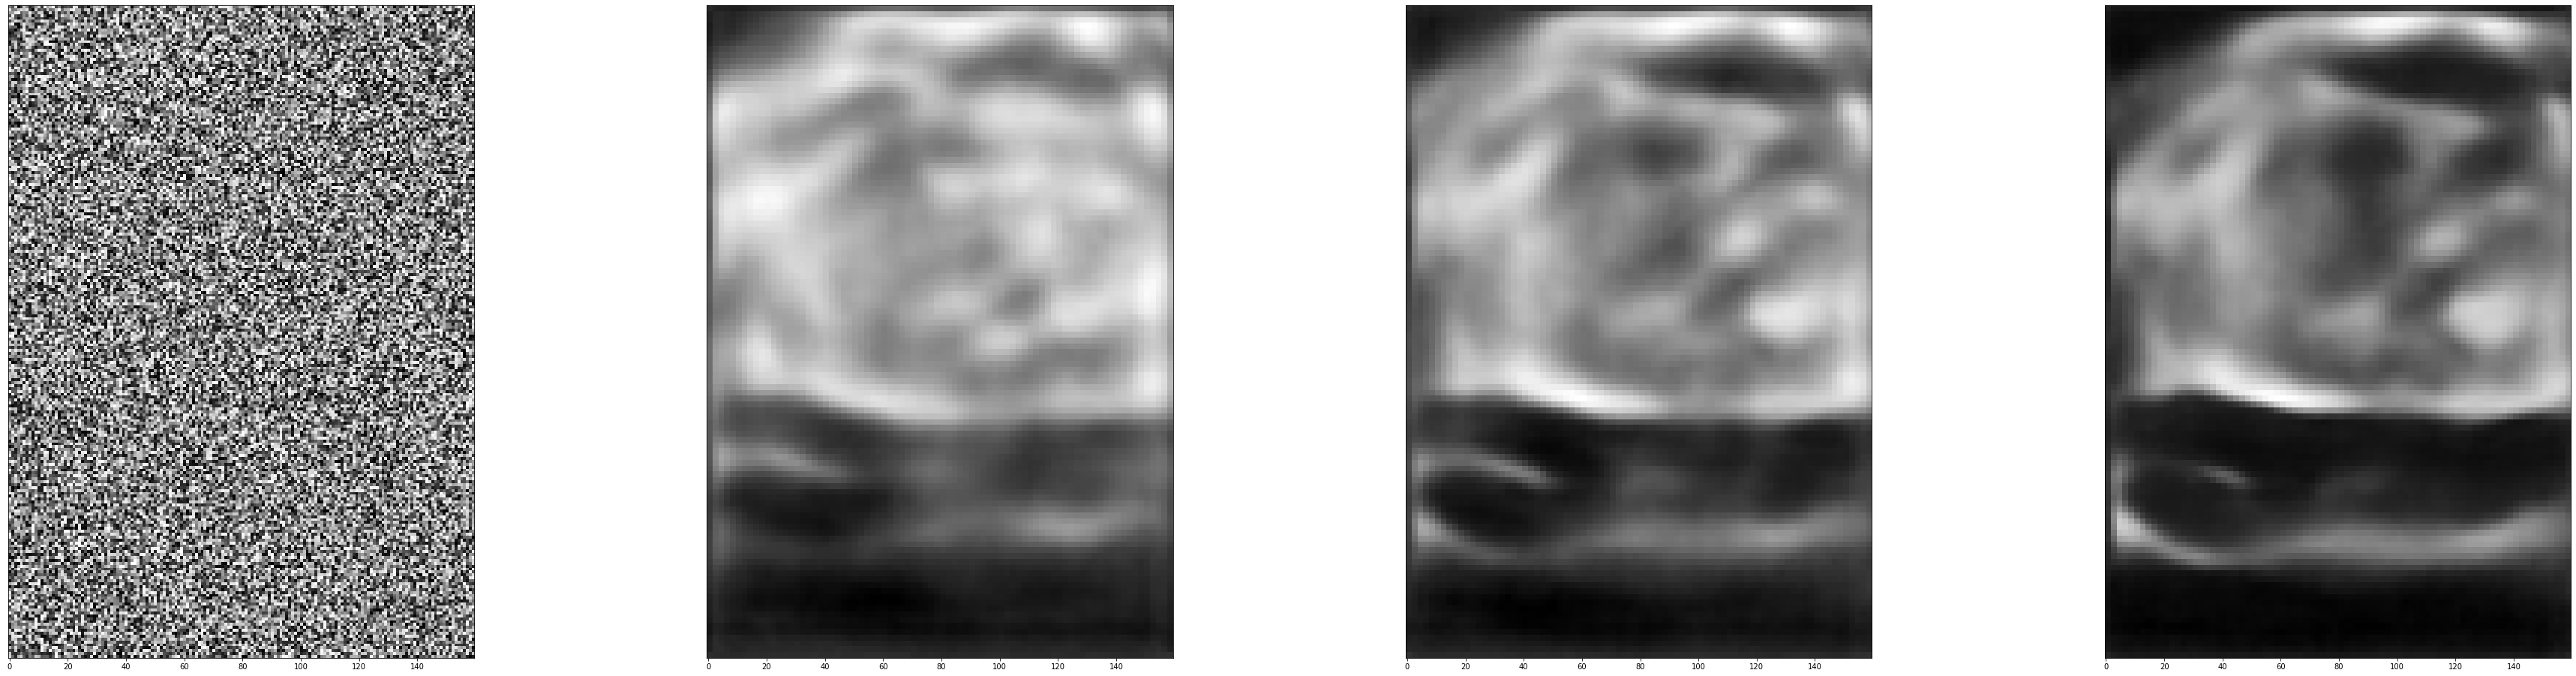

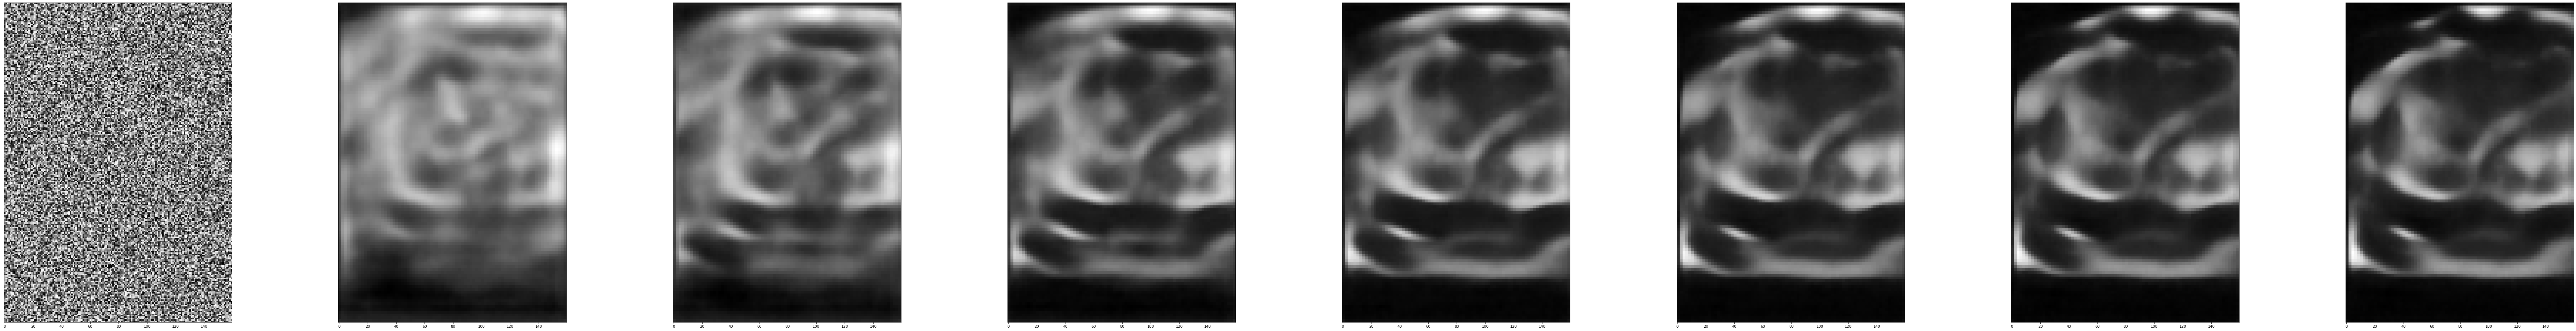

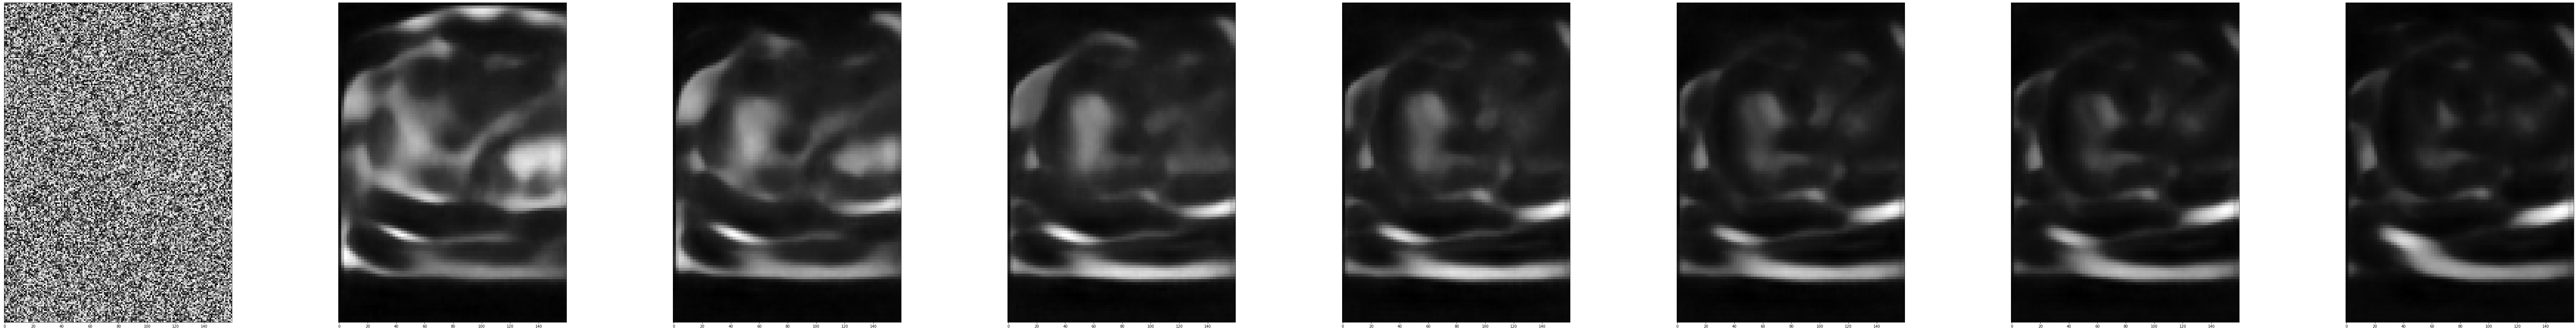

In [31]:
m = plot_ae_towards_attractor(model,  np.random.uniform(-1, 1, (1,224,160,1)), samples = 3, steps=150)
m = plot_ae_towards_attractor(model,  np.random.uniform(-1, 1, (1,224,160,1)), samples = 4, steps=4)
m = plot_ae_towards_attractor(model,  np.random.random((1,224,160,1)), samples=8, steps = 8)
m = plot_ae_towards_attractor(model,  np.random.random((1,224,160,1)), samples=8, steps = 48)

In [19]:
def pca_on_matrix(matrix, pca_components):
    pca = PCA()
    pca.fit(matrix)
    print(f'PCA explains {100*np.sum(pca.explained_variance_ratio_[:pca_components]):0.1f}% of variance with {pca_components} top PCA components.')
    matrix_reduced = pca.transform(matrix)[:, :pca_components]
    print(f'PCA reduces matrix shape:{matrix_reduced.shape} from matrix shape: {matrix.shape}')
    plot_scree(pca_components, 100*pca.explained_variance_ratio_)
    return pca, matrix_reduced

def plot_scree(pca_components, percent_explained):
    _ = plt.figure(figsize=(6, 4))
    plt.plot(range(len(percent_explained)), percent_explained, 'g.-', linewidth=1)
    plt.axvline(x=pca_components, c='r', linewidth=3)
    label = f'{np.sum(percent_explained[:pca_components]):0.1f}% of variance explained by top {pca_components} of {len(percent_explained)} components'
    plt.text(pca_components+0.02*len(percent_explained), percent_explained[1], label)
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('% of Variance Explained by Each Component')
    figure_path = f'./results/pca_{pca_components}_of_{len(percent_explained)}_testimonials.png'
    if not os.path.exists(os.path.dirname(figure_path)):
        os.makedirs(os.path.dirname(figure_path))
    plt.savefig(figure_path)
    
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def directions_in_latent_space(stratify_column, stratify_thresh, split_column, split_thresh, latent_cols):
    hit1 = latent_df.loc[(latent_df[stratify_column] >= stratify_thresh) 
                        & (latent_df[split_column] >= split_thresh)][latent_cols].to_numpy()
    miss1 = latent_df.loc[(latent_df[stratify_column] < stratify_thresh) 
                        & (latent_df[split_column] >= split_thresh)][latent_cols].to_numpy()
    hit2 = latent_df.loc[(latent_df[stratify_column] >= stratify_thresh) 
                        & (latent_df[split_column] < split_thresh)][latent_cols].to_numpy()
    miss2 = latent_df.loc[(latent_df[stratify_column] < stratify_thresh) 
                        & (latent_df[split_column] < split_thresh)][latent_cols].to_numpy()
    miss_mean_vector1 = np.mean(miss1, axis=0)
    hit_mean_vector1 = np.mean(hit1, axis=0)
    angle1 = angle_between(miss_mean_vector1, hit_mean_vector1)
    miss_mean_vector2 = np.mean(miss2, axis=0)
    hit_mean_vector2 = np.mean(hit2, axis=0)
    angle2 = angle_between(miss_mean_vector2, hit_mean_vector2)
    print(f'Angle between {stratify_column} and splits: {angle1}, {angle2}\n'
          f'split_column between {split_column} and all others: {split_thresh}, \n'
          f'Hit1 shape {hit1.shape}, miss1:{miss1.shape} threshold:{stratify_thresh}\n'
          f'Hit2 shape {hit2.shape}, miss2:{miss2.shape}\n')

def stratify_latent_space(stratify_column, stratify_thresh, latent_cols):
    hit = latent_df.loc[latent_df[stratify_column] >= stratify_thresh][latent_cols].to_numpy()
    miss = latent_df.loc[latent_df[stratify_column] < stratify_thresh][latent_cols].to_numpy()
    miss_mean_vector = np.mean(miss, axis=0)
    hit_mean_vector = np.mean(hit, axis=0)
    angle = angle_between(miss_mean_vector, hit_mean_vector)
    print(f'Angle between {stratify_column} and all others: {angle}, \n'
          f'Hit shape {hit.shape}, miss:{miss.shape} threshold:{stratify_thresh}\n')
    
def plot_pcs(sides, color_key):
    f, axes = plt.subplots(sides, sides, figsize=(16, 16))
    for i, ax in enumerate(axes.ravel()):
        colors = latent_df[color_key].to_numpy()
        points = ax.scatter(matrix_reduce[:, i], matrix_reduce[:, i+1], c=colors)
        f.colorbar(points, ax=ax)
        


In [15]:
df = pd.read_csv('/home/sam/ml/trained_models/lax_4ch_diastole_autoencode_leaky_converge/tensors_all_union.csv')
df['21003_Age-when-attended-assessment-centre_2_0'].plot.hist(bins=30)
df2 = pd.read_csv('/home/sam/ml/trained_models/lax_4ch_diastole_leaky_wide_autoencode2/hidden_inference_lax_4ch_diastole_leaky_wide_autoencode2.tsv', sep='\t')
df['fpath'] = pd.to_numeric(df['fpath'], errors='coerce')
df2['sample_id'] = pd.to_numeric(df2['sample_id'], errors='coerce')
df.info()
latent_df = pd.merge(df, df2, left_on='fpath', right_on='sample_id', how='inner')
latent_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45682 entries, 0 to 45681
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   21003_Age-when-attended-assessment-centre_2_0  45681 non-null  float64
 1   21001_Body-mass-index-BMI_0_0                  45614 non-null  float64
 2   LA_2Ch_vol_max                                 4525 non-null   float64
 3   LA_2Ch_vol_min                                 4522 non-null   float64
 4   LA_4Ch_vol_max                                 4548 non-null   float64
 5   LA_4Ch_vol_min                                 4544 non-null   float64
 6   LA_Biplan_vol_max                              4425 non-null   float64
 7   LA_Biplan_vol_min                              4425 non-null   float64
 8   LVEDV                                          4705 non-null   float64
 9   LVEF                                           468

In [16]:
latent_df.head()

21003_Age-when-attended-assessment-centre_2_0  \
0                                           72.0   
1                                           62.0   
2                                           66.0   
3                                           70.0   
4                                           48.0   

   21001_Body-mass-index-BMI_0_0  LA_2Ch_vol_max  LA_2Ch_vol_min  \
0                        22.2875             NaN             NaN   
1                        20.5533             NaN             NaN   
2                        27.5779             NaN             NaN   
3                        25.6015             NaN             NaN   
4                        26.4919             NaN             NaN   

   LA_4Ch_vol_max  LA_4Ch_vol_min  LA_Biplan_vol_max  LA_Biplan_vol_min  \
0             NaN             NaN                NaN                NaN   
1             NaN             NaN                NaN                NaN   
2             NaN             NaN                NaN                NaN   
3             NaN             NaN                NaN                NaN   
4             NaN             NaN                NaN                NaN   

   LVEDV  LVEF  ...  latent_246  latent_247  latent_248  latent_249  \
0    NaN   NaN  ...   11.172012    4.260541    3.470167   12.389126   
1    NaN   NaN  ...    7.878465    4.567312    7.307088   17.126982   
2    NaN   NaN  ...    4.770548    3.615223    6.610302    6.064508   
3    NaN   NaN  ...    2.097342    4.821303    4.601469   11.476638   
4    NaN   NaN  ...    5.201735    6.154121   -2.126784    9.875897   

   latent_250  latent_251  latent_252  latent_253  latent_254  latent_255  
0    0.695792    0.142917    4.231380    6.519005    9.896664   -0.561860  
1    4.447500    1.187220   12.473096    8.955857    5.583265   11.865533  
2    0.428634    6.466238    6.693902    6.744361    5.556402    5.390053  
3    5.541372    2.361737    3.272003    0.076841    1.623132    0.153328  
4    5.075258    4.853335    8.590025    8.525858   12.223067    2.906217  

[5 rows x 294 columns]

### Latent space of the Non-U-net CNN has clear alignments for basic phenotypes
- BMI, sex, left ventricle mass, afib and CAD diagnosis showed large differences in Radians.
- Sanity check: stratifying by sample ID does not show much alignment.

In [17]:
import matplotlib.pyplot as plt
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
pca, matrix_reduce = pca_on_matrix(df2[latent_cols].to_numpy(), 10)
for strat in ['Sex_Female_0_0', 'atrial_fibrillation_or_flutter', 
              'coronary_artery_disease', 'hypertension']:
    stratify_latent_space(strat, 1.0, latent_cols)
strats = ['LVEF', 'LVM', 'LVEDV', 'sample_id',
              '21001_Body-mass-index-BMI_0_0', '21003_Age-when-attended-assessment-centre_2_0']
theshes = [50, 100, 150, 2500000, 27.5, 80]
for strat, thresh in zip(strats, theshes):
    stratify_latent_space(strat, thresh, latent_cols)

PCA explains 41.0% of variance with 10 top PCA components.
PCA reduces matrix shape:(43379, 10) from matrix shape: (43379, 256)
Angle between Sex_Female_0_0 and all others: 0.30412259057419905, 
Hit shape (22514, 256), miss:(20865, 256) threshold:1.0

Angle between atrial_fibrillation_or_flutter and all others: 0.13040878165652525, 
Hit shape (1691, 256), miss:(41688, 256) threshold:1.0

Angle between coronary_artery_disease and all others: 0.1439435899455497, 
Hit shape (1586, 256), miss:(41793, 256) threshold:1.0

Angle between hypertension and all others: 0.12448794584480274, 
Hit shape (13958, 256), miss:(29421, 256) threshold:1.0

Angle between LVEF and all others: 0.12542668931987627, 
Hit shape (4179, 256), miss:(261, 256) threshold:50

Angle between LVM and all others: 0.2590399504641123, 
Hit shape (1380, 256), miss:(3074, 256) threshold:100

Angle between LVEDV and all others: 0.22738220264461614, 
Hit shape (1737, 256), miss:(2718, 256) threshold:150

Angle between sample_id

### Latent space of the U-net CNN does not have as clear alignments for basic phenotypes
- Phenotype rank is consistent ie BMI, sex, left ventricle mass had larger differences in Radians.
- Sanity check: stratifying by sample ID does not show much alignment.

In [21]:
import matplotlib.pyplot as plt
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
pca, matrix_reduce = pca_on_matrix(df2[latent_cols].to_numpy(), 10)
c_strats = ['Sex_Female_0_0', 'atrial_fibrillation_or_flutter', 'coronary_artery_disease', 'hypertension']
for c_strat in c_strats:
    strats = ['LVEF', 'LVM', 'LVEDV', 'sample_id',
                  '21001_Body-mass-index-BMI_0_0', '21003_Age-when-attended-assessment-centre_2_0']
    theshes = [50, 100, 150, 2500000, 27.5, 80]
    for strat, thresh in zip(strats, theshes):
        directions_in_latent_space(strat, thresh, c_strat, 1.0, latent_cols)

PCA explains 41.0% of variance with 10 top PCA components.
PCA reduces matrix shape:(43379, 10) from matrix shape: (43379, 256)
Angle between LVEF and splits: 0.10387834710628041, 0.07931107542407764
split_column between Sex_Female_0_0 and all others: 1.0, 
Hit1 shape (2265, 256), miss1:(69, 256) threshold:50
Hit2 shape (1914, 256), miss2:(192, 256)

Angle between LVM and splits: 0.25762303190978947, 0.15399659892941192
split_column between Sex_Female_0_0 and all others: 1.0, 
Hit1 shape (114, 256), miss1:(2229, 256) threshold:100
Hit2 shape (1266, 256), miss2:(845, 256)

Angle between LVEDV and splits: 0.1780414902030569, 0.11387353261361545
split_column between Sex_Female_0_0 and all others: 1.0, 
Hit1 shape (359, 256), miss1:(1985, 256) threshold:150
Hit2 shape (1378, 256), miss2:(733, 256)

Angle between sample_id and splits: 0.010712591966528556, 0.011399423098944674
split_column between Sex_Female_0_0 and all others: 1.0, 
Hit1 shape (15397, 256), miss1:(7117, 256) threshold:2500

In [7]:
df = pd.read_csv('/home/sam/ml/trained_models/lax_4ch_diastole_autoencode_leaky_converge/tensors_all_union.csv')
df['21003_Age-when-attended-assessment-centre_2_0'].plot.hist(bins=30)
df2 = pd.read_csv('/home/sam/ml/trained_models/lax_4ch_diastole_autoencode_leaky_unet2/hidden_inference_lax_4ch_diastole_autoencode_leaky_unet2.tsv', sep='\t')
latent_df = pd.merge(df, df2, left_on='fpath', right_on='sample_id', how='inner')
latent_df.info()
latent_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29643 entries, 0 to 29642
Columns: 166 entries, 21003_Age-when-attended-assessment-centre_2_0 to latent_127
dtypes: float64(163), int64(2), object(1)
memory usage: 37.8+ MB


21003_Age-when-attended-assessment-centre_2_0  \
0                                           62.0   
1                                           66.0   
2                                           70.0   
3                                           48.0   
4                                           63.0   

   21001_Body-mass-index-BMI_0_0  LA_2Ch_vol_max  LA_2Ch_vol_min  \
0                        20.5533             NaN             NaN   
1                        27.5779             NaN             NaN   
2                        25.6015             NaN             NaN   
3                        26.4919             NaN             NaN   
4                        28.8474             NaN             NaN   

   LA_4Ch_vol_max  LA_4Ch_vol_min  LA_Biplan_vol_max  LA_Biplan_vol_min  \
0             NaN             NaN                NaN                NaN   
1             NaN             NaN                NaN                NaN   
2             NaN             NaN                NaN                NaN   
3             NaN             NaN                NaN                NaN   
4             NaN             NaN                NaN                NaN   

   LVEDV  LVEF  ...  latent_118  latent_119  latent_120  latent_121  \
0    NaN   NaN  ...   -0.028712   -0.021831    0.064718    0.032389   
1    NaN   NaN  ...   -0.024116   -0.019868    0.077808    0.041297   
2    NaN   NaN  ...   -0.024785   -0.016114    0.088783    0.032273   
3    NaN   NaN  ...   -0.035189   -0.013849    0.076415    0.015991   
4    NaN   NaN  ...   -0.012886   -0.009604    0.080711    0.040952   

   latent_122  latent_123  latent_124  latent_125  latent_126  latent_127  
0   -0.012191    0.052639   -0.024562    0.060843    0.043511    0.001942  
1   -0.017134    0.066052   -0.036571    0.061766    0.041362    0.000592  
2   -0.020278    0.057340   -0.017046    0.067478    0.042435    0.003889  
3   -0.019476    0.049947   -0.027681    0.060966    0.039640    0.015921  
4   -0.009512    0.038829   -0.022534    0.051448    0.034047   -0.006049  

[5 rows x 166 columns]

PCA explains 78.1% of variance with 10 top PCA components.
PCA reduces matrix shape:(29643, 10) from matrix shape: (29643, 128)
Angle between Sex_Female_0_0 and all others: 0.1558986120308701, 
Hit shape (16333, 128), miss:(13310, 128) threshold:1.0

Angle between atrial_fibrillation_or_flutter and all others: 0.11140375766877451, 
Hit shape (740, 128), miss:(28903, 128) threshold:1.0

Angle between coronary_artery_disease and all others: 0.09906341789721827, 
Hit shape (848, 128), miss:(28795, 128) threshold:1.0

Angle between hypertension and all others: 0.10501985485336139, 
Hit shape (7972, 128), miss:(21671, 128) threshold:1.0

Angle between LVEF and all others: 0.06673573899901965, 
Hit shape (2772, 128), miss:(160, 128) threshold:50

Angle between LVM and all others: 0.20159142842535938, 
Hit shape (938, 128), miss:(2006, 128) threshold:100

Angle between LVEDV and all others: 0.149855239917395, 
Hit shape (1152, 128), miss:(1793, 128) threshold:150

Angle between sample_id and 

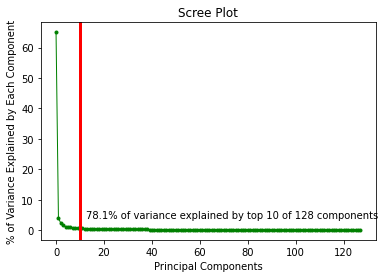

In [30]:
latent_dimension = 128
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
pca, matrix_reduce = pca_on_matrix(df2[latent_cols].to_numpy(), 10)
for strat in ['Sex_Female_0_0', 'atrial_fibrillation_or_flutter', 
              'coronary_artery_disease', 'hypertension']:
    stratify_latent_space(strat, 1.0, latent_cols)
strats = ['LVEF', 'LVM', 'LVEDV', 'sample_id',
              '21001_Body-mass-index-BMI_0_0', '21003_Age-when-attended-assessment-centre_2_0']
theshes = [50, 100, 150, 2500000, 27.5, 80]
for strat, thresh in zip(strats, theshes):
    stratify_latent_space(strat, thresh, latent_cols)

In [2]:
def make_paired_model(
    pairs: List[Tuple[TensorMap, TensorMap]],
    **kwargs
) -> Model:
    inputs = {tm: Input(shape=tm.shape, name=tm.input_name()) for tm in args.tensor_maps_in}
    multimodal_activations = []
    desired_distance_tm = []
    my_metrics = {}
    outputs = []
    losses = []
    for left, right in pairs:
        args.tensor_maps_in = [left]
        left_model = make_multimodal_multitask_model(**args.__dict__)
        encode_left = make_hidden_layer_model(left_model, [left], args.hidden_layer)
        args.tensor_maps_in = [right]
        right_model = make_multimodal_multitask_model(**args.__dict__)
        encode_right = make_hidden_layer_model(right_model, [right], args.hidden_layer)
        
        h_left = encode_left(inputs[left])
        h_right = encode_right(inputs[right])
        print(f'Encoded left and right...')
        
        tff = lambda tm, hd5, d: np.zeros((1,))
        tm0 = TensorMap(f'paired_{left.name}_{right.name}', shape=(1,), tensor_from_file=tff)
        desired_distance_tm.append(tm0)
        
        # Compute the L2 distance
        l2_layer = Lambda(lambda tensors: K.mean(K.square(tensors[0] - tensors[1]), axis=-1, keepdims=True), name=tm0.output_name())
        l2_distance = l2_layer([h_left, h_right])
        outputs.append(l2_distance)
        losses.append('binary_crossentropy')
        multimodal_activations.extend([h_left, h_right])

    multimodal_activation = Concatenate()(multimodal_activations)  # TODO: also add non-paired inputs here
    for ot in args.tensor_maps_out:
        losses.append(ot.loss)
        my_metrics[ot.output_name()] = ot.metrics
        out_layer = Dense(units=len(ot.channel_map), activation=ot.activation, name=ot.output_name())
        outputs.append(out_layer(multimodal_activation))
    
    args.tensor_maps_out.extend(desired_distance_tm)
    args.tensor_maps_in = list(inputs.keys())
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    m = Model(inputs=list(inputs.values()), outputs=outputs)
    m.compile(optimizer=opt, loss=losses, metrics=my_metrics)
    m.summary()

    return m

In [14]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/segmented-sax-lax/2020-07-07/', 
            '--input_tensors', 'lax_4ch_diastole_slice0_224_3d', 'lax_3ch_diastole_slice0_3d',
            '--output_tensors', 'bmi_21',
            '--batch_size', '6',
            '--epochs', '24',
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '12',
            '--num_workers', '0',
            '--inspect_model',
            '--id', 'lax_3ch_4ch_diastole_paired_autoencoder']
args = parse_args()
pairs = [(args.tensor_maps_in[0], args.tensor_maps_in[1])]
paired_model = make_paired_model(pairs, **args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
train_model_from_generators(
        paired_model, generate_train, generate_valid, args.training_steps, args.validation_steps, args.batch_size,
        args.epochs, args.patience, args.output_folder, args.id, args.inspect_model, args.inspect_show_labels,
)

2020-08-03 09:00:44,032 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/lax_3ch_4ch_diastole_paired_autoencoder/log_2020-08-03_09-00_0.log.
2020-08-03 09:00:44,034 - arguments:423 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/segmented-sax-lax/2020-07-07/ --input_tensors lax_4ch_diastole_slice0_224_3d lax_3ch_diastole_slice0_3d --output_tensors bmi_21 --batch_size 6 --epochs 24 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 12 --num_workers 0 --inspect_model --id lax_3ch_4ch_diastole_paired_autoencoder

2020-08-03 09:00:44,035 - arguments:424 - INFO - Total TensorMaps: 599 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='br

Trainable params: 253,929
Non-trainable params: 0
__________________________________________________________________________________________________
2020-08-03 09:00:44,385 - models:835 - WARNING - Number of x dimensions for convolutional kernel sizes (1) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-03 09:00:44,386 - models:835 - WARNING - Number of y dimensions for convolutional kernel sizes (1) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-03 09:00:44,387 - models:835 - WARNING - Number of z dimensions for convolutional kernel sizes (1) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-03 09:00:44,389 - models:383 - INFO - Residual Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3))]
2020-08-03 09:00:44,393 - models:421 - INFO - Dense Block Convolutional Lay

Encoded left and right...
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lax_4ch_diastole_slice0_2 [(None, 160, 224, 1) 0                                            
__________________________________________________________________________________________________
input_lax_3ch_diastole_slice0_3 [(None, 200, 160, 1) 0                                            
__________________________________________________________________________________________________
model_21 (Model)                (None, 64)           253864      input_lax_4ch_diastole_slice0_224
__________________________________________________________________________________________________
model_23 (Model)                (None, 64)           238504      input_lax_3ch_diastole_slice0_3d_
_________________________________________________________________

In [3]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/segmented-sax-lax/2020-07-07/', 
            '--input_tensors', 'lax_4ch_diastole_slice0_224_3d', 'lax_3ch_diastole_slice0_3d',
            '--output_tensors', 'bmi_21', 'sex',
            '--batch_size', '4',
            '--epochs', '32',
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '12',
            '--num_workers', '0',
            '--inspect_model',
            '--id', 'lax_3ch_4ch_diastole_paired_autoencoder_bmi_sex']
args = parse_args()
pairs = [(args.tensor_maps_in[0], args.tensor_maps_in[1])]
paired_model = make_paired_model(pairs, **args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
train_model_from_generators(
        paired_model, generate_train, generate_valid, args.training_steps, args.validation_steps, args.batch_size,
        args.epochs, args.patience, args.output_folder, args.id, args.inspect_model, args.inspect_show_labels,
)

2020-08-03 13:10:36,069 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/lax_3ch_4ch_diastole_paired_autoencoder_bmi_sex/log_2020-08-03_13-10_0.log.
2020-08-03 13:10:36,070 - arguments:423 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/segmented-sax-lax/2020-07-07/ --input_tensors lax_4ch_diastole_slice0_224_3d lax_3ch_diastole_slice0_3d --output_tensors bmi_21 sex --batch_size 4 --epochs 32 --learning_rate 0.001 --training_steps 128 --validation_steps 10 --test_steps 12 --num_workers 0 --inspect_model --id lax_3ch_4ch_diastole_paired_autoencoder_bmi_sex

2020-08-03 13:10:36,070 - arguments:424 - INFO - Total TensorMaps: 599 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=4, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', 

2020-08-03 13:10:38,010 - models:835 - WARNING - Number of x dimensions for convolutional kernel sizes (1) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-03 13:10:38,012 - models:835 - WARNING - Number of y dimensions for convolutional kernel sizes (1) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-03 13:10:38,012 - models:835 - WARNING - Number of z dimensions for convolutional kernel sizes (1) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-03 13:10:38,015 - models:383 - INFO - Residual Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3))]
2020-08-03 13:10:38,019 - models:421 - INFO - Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
2020-08-03 13:10:38,023 - models:421 - INFO - Dense Block Convolutional La

Encoded left and right...
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lax_4ch_diastole_slice0_2 [(None, 160, 224, 1) 0                                            
__________________________________________________________________________________________________
input_lax_3ch_diastole_slice0_3 [(None, 200, 160, 1) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 64)           253864      input_lax_4ch_diastole_slice0_224
__________________________________________________________________________________________________
model_3 (Model)                 (None, 64)           238504      input_lax_3ch_diastole_slice0_3d_
__________________________________________________________________

Epoch 3/32
127/128 [============================>.] - ETA: 0s - loss: 0.5343 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0899 - output_Sex_Male_0_0_categorical_loss: 0.2524 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1920 - output_Sex_Male_0_0_categorical_categorical_accuracy: 0.9272 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_precision: 0.8497 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_precision: 0.8766 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_recall: 0.8412 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_recall: 0.8747 - output_21001_Body-mass-index-BMI_0_0_continuous_pearson: 0.6564
Epoch 00003: val_loss did not improve from 0.45058
128/128 [==============================] - 22s 169ms/step - loss: 0.5338 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0899 - output_Sex_Male_0_0_categorical_loss: 0.2520 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1

Epoch 7/32
127/128 [============================>.] - ETA: 0s - loss: 0.4055 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0686 - output_Sex_Male_0_0_categorical_loss: 0.1736 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1633 - output_Sex_Male_0_0_categorical_categorical_accuracy: 0.9528 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_precision: 0.9121 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_precision: 0.8852 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_recall: 0.9396 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_recall: 0.8675 - output_21001_Body-mass-index-BMI_0_0_continuous_pearson: 0.7045
Epoch 00007: val_loss did not improve from 0.30552
128/128 [==============================] - 20s 157ms/step - loss: 0.4038 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0686 - output_Sex_Male_0_0_categorical_loss: 0.1727 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1

Epoch 11/32
127/128 [============================>.] - ETA: 0s - loss: 0.3213 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0628 - output_Sex_Male_0_0_categorical_loss: 0.1117 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1468 - output_Sex_Male_0_0_categorical_categorical_accuracy: 0.9606 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_precision: 0.9265 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_precision: 0.9127 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_recall: 0.9206 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_recall: 0.9199 - output_21001_Body-mass-index-BMI_0_0_continuous_pearson: 0.6904
Epoch 00011: val_loss did not improve from 0.26729
128/128 [==============================] - 19s 148ms/step - loss: 0.3198 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0629 - output_Sex_Male_0_0_categorical_loss: 0.1110 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.

Epoch 15/32
127/128 [============================>.] - ETA: 0s - loss: 0.2624 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0518 - output_Sex_Male_0_0_categorical_loss: 0.0885 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1221 - output_Sex_Male_0_0_categorical_categorical_accuracy: 0.9764 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_precision: 0.9370 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_precision: 0.9259 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_recall: 0.9403 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_recall: 0.9160 - output_21001_Body-mass-index-BMI_0_0_continuous_pearson: 0.7262
Epoch 00015: val_loss did not improve from 0.22241
128/128 [==============================] - 74s 577ms/step - loss: 0.2625 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0517 - output_Sex_Male_0_0_categorical_loss: 0.0884 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.

Epoch 19/32
127/128 [============================>.] - ETA: 0s - loss: 0.2702 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0442 - output_Sex_Male_0_0_categorical_loss: 0.0862 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1398 - output_Sex_Male_0_0_categorical_categorical_accuracy: 0.9803 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_precision: 0.8917 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_precision: 0.8924 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_recall: 0.9003 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_recall: 0.8924 - output_21001_Body-mass-index-BMI_0_0_continuous_pearson: 0.6950
Epoch 00019: val_loss did not improve from 0.14810
128/128 [==============================] - 73s 571ms/step - loss: 0.2687 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0441 - output_Sex_Male_0_0_categorical_loss: 0.0858 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.

127/128 [============================>.] - ETA: 0s - loss: 0.2296 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0388 - output_Sex_Male_0_0_categorical_loss: 0.0781 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1127 - output_Sex_Male_0_0_categorical_categorical_accuracy: 0.9744 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_precision: 0.9619 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_precision: 0.8681 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_recall: 0.9547 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_recall: 0.8806 - output_21001_Body-mass-index-BMI_0_0_continuous_pearson: 0.7083
Epoch 00023: val_loss did not improve from 0.14810
128/128 [==============================] - 77s 599ms/step - loss: 0.2292 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0389 - output_Sex_Male_0_0_categorical_loss: 0.0781 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1123 - outpu

Epoch 27/32
127/128 [============================>.] - ETA: 0s - loss: 0.2337 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0332 - output_Sex_Male_0_0_categorical_loss: 0.0744 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1261 - output_Sex_Male_0_0_categorical_categorical_accuracy: 0.9783 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_precision: 0.9259 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_precision: 0.9108 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_recall: 0.9304 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_recall: 0.9134 - output_21001_Body-mass-index-BMI_0_0_continuous_pearson: 0.7750
Epoch 00027: val_loss did not improve from 0.14810
128/128 [==============================] - 79s 614ms/step - loss: 0.2326 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0332 - output_Sex_Male_0_0_categorical_loss: 0.0739 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.

127/128 [============================>.] - ETA: 0s - loss: 0.2329 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0307 - output_Sex_Male_0_0_categorical_loss: 0.0827 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1194 - output_Sex_Male_0_0_categorical_categorical_accuracy: 0.9665 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_precision: 0.8780 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_precision: 0.8661 - output_Sex_Male_0_0_categorical_Sex_Female_0_0_recall: 0.8629 - output_Sex_Male_0_0_categorical_Sex_Male_0_0_recall: 0.8688 - output_21001_Body-mass-index-BMI_0_0_continuous_pearson: 0.7503
Epoch 00031: val_loss did not improve from 0.14810
128/128 [==============================] - 78s 613ms/step - loss: 0.2324 - output_paired_lax_4ch_diastole_slice0_224_3d_lax_3ch_diastole_slice0_3d_continuous_loss: 0.0306 - output_Sex_Male_0_0_categorical_loss: 0.0825 - output_21001_Body-mass-index-BMI_0_0_continuous_loss: 0.1193 - outpu

<Figure size 2304x1728 with 0 Axes>

In [8]:
def make_autoencoded_model(
    **kwargs
) -> Model:
    inputs = [Input(shape=tm.shape, name=tm.input_name()) for tm in args.tensor_maps_in]
    multimodal_activations = []
    
    my_metrics = {}
    outputs = []
    losses = []
    kernel = (args.conv_x[0], args.conv_y[0])
    cur_shape = list(args.tensor_maps_in[0].shape)
    x = Conv2D(args.conv_layers[0], kernel_size=kernel, activation='linear', use_bias=False, padding='same')(inputs[0])
    for filters in args.conv_layers[1:]:
        x = Conv2D(filters, kernel_size=kernel, activation='linear', use_bias=False, padding='same')(x)
        x = Activation('selu')(x)
        x = MaxPooling2D((args.pool_x, args.pool_y))(x)
        x = Dropout(args.conv_regularize_rate)(x)
        cur_shape[0] //= args.pool_x
        cur_shape[1] //= args.pool_y
    
    if len(args.dense_layers) > 0:
        x = Flatten()(x)
        for units in args.dense_layers:
            x = Dense(units, activation='linear', use_bias=False)(x)
            x = Activation('selu')(x)

        x = Dense(int(np.prod(cur_shape)), activation='linear', use_bias=False)(x)
        x = Activation('selu')(x)
        x = Reshape(tuple(cur_shape))(x)
        
    for filters in args.conv_layers[1:]:
        x = Conv2D(filters, kernel_size=kernel, activation='linear', use_bias=False, padding='same')(x)
        x = Activation('selu')(x)
        x = UpSampling2D((args.pool_x, args.pool_y))(x)

    for ot in args.tensor_maps_out:
        losses.append(ot.loss)
        my_metrics[ot.output_name()] = ot.metrics
        x = Dense(ot.shape[-1], activation='linear', use_bias=False, name=f'preactivation_{ot.output_name()}')(x)
        x = Activation('selu', name=ot.output_name())(x)
        outputs.append(x)
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    m = Model(inputs=inputs, outputs=outputs)
    m.compile(optimizer=opt, loss=losses, metrics=my_metrics)
    m.summary()

    return m

In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/segmented-sax-lax/2020-07-07/', 
            '--input_tensors', 'lax_4ch_diastole_slice0_224_3d', 
            '--output_tensors', 'lax_4ch_diastole_slice0_224_3d',
            '--conv_layers', '128', '128', '128',
            '--dense_layers', '128',
            '--batch_size', '2',
            '--epochs', '72',
            '--learning_rate', '0.001',
            '--training_steps', '256',
            '--validation_steps', '30',
            '--test_steps', '12',
            '--num_workers', '0',
            '--inspect_model',
            '--id', 'lax_4ch_diastole_autoencoder']
args = parse_args()
overparameterized_model = make_autoencoded_model(**args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
train_model_from_generators(
        overparameterized_model, generate_train, generate_valid, args.training_steps, args.validation_steps, args.batch_size,
        args.epochs, args.patience, args.output_folder, args.id, args.inspect_model, args.inspect_show_labels,
)

2020-08-03 15:12:31,875 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/lax_4ch_diastole_autoencoder/log_2020-08-03_15-12_0.log.
2020-08-03 15:12:31,876 - arguments:423 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/segmented-sax-lax/2020-07-07/ --input_tensors lax_4ch_diastole_slice0_224_3d --output_tensors lax_4ch_diastole_slice0_224_3d --conv_layers 128 128 128 --dense_layers 128 --batch_size 2 --epochs 72 --learning_rate 0.001 --training_steps 256 --validation_steps 30 --test_steps 12 --num_workers 0 --inspect_model --id lax_4ch_diastole_autoencoder

2020-08-03 15:12:31,877 - arguments:424 - INFO - Total TensorMaps: 599 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=2, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', 

256/256 [==============================] - 11s 43ms/step - loss: 0.5929 - val_loss: 0.4640
2020-08-03 15:12:45,813 - models:1293 - INFO - Spent:11.12 seconds training, Samples trained on:512 Per sample training speed:0.022 seconds.
32/32 [==============================] - 1s 40ms/step
2020-08-03 15:12:47,171 - models:1299 - INFO - Spent:1.36 seconds predicting, Samples inferred:512 Per sample inference speed:0.0212 seconds.
Train for 256 steps, validate for 30 steps
Epoch 1/72
255/256 [============================>.] - ETA: 0s - loss: 0.4710
Epoch 00001: val_loss improved from inf to 0.41393, saving model to ./recipes_output/lax_4ch_diastole_autoencoder/lax_4ch_diastole_autoencoder.h5
256/256 [==============================] - 17s 68ms/step - loss: 0.4711 - val_loss: 0.4139
Epoch 2/72
255/256 [============================>.] - ETA: 0s - loss: 0.4495
Epoch 00002: val_loss improved from 0.41393 to 0.38014, saving model to ./recipes_output/lax_4ch_diastole_autoencoder/lax_4ch_diastole_aut